In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pyspark
import pyspark.sql.functions as F

from tqdm import tqdm

from collections import Counter

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, MapType, NumericType, ArrayType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer, VectorAssembler, StandardScaler

import sklearn.preprocessing
from sklearn.decomposition import PCA

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 05:35:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Build Bronze Tables

**Determine partitions** 

Here we decide to partition by dates

In [31]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [32]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

**Create data lake for bronze tables**

In [11]:
# create bronze datalake
bronze_directory = "datamart/bronze"

if not os.path.exists(bronze_directory):
    os.makedirs(bronze_directory)

In [6]:
def process_bronze_table(table_name, source, db, snapshot_date_str, spark):
    # create bronze table 
    bronze_table = os.path.join(db, table_name)
    if not os.path.exists(bronze_table):
        os.makedirs(bronze_table)

    # prepare arguments
    snapshot_date = datetime.strptime(snapshot_date_str, "%Y-%m-%d")

    # load data - IRL ingest from back end source system
    df = spark.read.csv(source, header=True, inferSchema=True).filter(col('snapshot_date') == snapshot_date)

    # save bronze table to datamart - IRL connect to database to write
    partition_name = snapshot_date_str.replace('-','_') + '.csv'
    filepath = os.path.join(bronze_table, partition_name)
    df.toPandas().to_csv(filepath, index=False)

    return df

Create bronze tables

In [7]:
for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing clickstream"):
    process_bronze_table('clickstream', 'data/feature_clickstream.csv', bronze_directory, date_str, spark)

for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing attributes"):
    process_bronze_table('attributes', 'data/features_attributes.csv', bronze_directory, date_str, spark)

for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing financials"):
    process_bronze_table('financials', 'data/features_financials.csv', bronze_directory, date_str, spark)

for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing lms"):
    process_bronze_table('lms', 'data/lms_loan_daily.csv', bronze_directory, date_str, spark)

Processing clickstream:   0%|          | 0/24 [00:00<?, ?it/s]

Processing lms: 100%|██████████| 24/24 [00:16<00:00,  1.47it/s]


# Build Silver Tables

## EDA

Take a peek at the bronze tables to find out what sort of preprocessing is needed.

- Tables attributes and financials denote the state of the customer when they first take out a loan from the Loan Management System
- Table lms tracks customers' loan payments for all loans made from 1 January 2023 to 1 December 2024

In [7]:
df_clickstream = pd.read_csv(f"{bronze_directory}/clickstream/2023_01_01.csv")
df_clickstream.head()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,63,118,80,121,55,193,111,112,-101,83,...,-16,-81,-126,114,35,85,-73,76,CUS_0x1037,2023-01-01
1,-108,182,123,4,-56,27,25,-6,284,222,...,-14,-96,200,35,130,94,111,75,CUS_0x1069,2023-01-01
2,-13,8,87,166,214,-98,215,152,129,139,...,26,86,171,125,-130,354,17,302,CUS_0x114a,2023-01-01
3,-85,45,200,89,128,54,76,51,61,139,...,172,96,174,163,37,207,180,118,CUS_0x1184,2023-01-01
4,55,120,226,-86,253,97,107,68,103,126,...,76,43,183,159,-26,104,118,184,CUS_0x1297,2023-01-01


In [23]:
df_attributes = pd.read_csv(f"{bronze_directory}/attributes/2023_01_01.csv")
df_attributes.head()

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1037,Matthewm,45,230-22-9583,Accountant,2023-01-01
1,CUS_0x1069,Andreas Cremero,32,761-27-5143,Accountant,2023-01-01
2,CUS_0x114a,Valetkevitchu,43,133-89-5234,Developer,2023-01-01
3,CUS_0x1184,Cohenq,49,963-76-2464,Lawyer,2023-01-01
4,CUS_0x1297,Edwardsz,46,#F%$D@*&8,Manager,2023-01-01


In [70]:
df_financials = pd.read_csv(f"{bronze_directory}/financials/2023_01_01.csv")
df_financials.head()

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x1037,15989.085,1086.423750,5,4,2,4,"Credit-Builder Loan, Auto Loan, Auto Loan, and...",13,15,...,Good,665.82,40.697699,19 Years and 9 Months,No,33.797021,80.46523951443457,Low_spent_Small_value_payments,284.380115,2023-01-01
1,CUS_0x1069,58637.34,4799.445000,4,6,10,119,"Personal Loan, Auto Loan, and Not Specified",9,17,...,Standard,208.8,25.233144,30 Years and 8 Months,Yes,139.885013,165.21061289035896,High_spent_Small_value_payments,434.848874,2023-01-01
2,CUS_0x114a,15305.46,1230.455000,0,7,2,2,"Student Loan, and Home Equity Loan",14,2,...,Good,642.42_,27.525113,15 Years and 9 Months,No,20.301654,64.77848007633177,Low_spent_Small_value_payments,327.965366,2023-01-01
3,CUS_0x1184,19867.475,1396.622917,3,5,11,3,"Student Loan, Mortgage Loan, and Payday Loan",10,9,...,Good,707.29,26.689790,32 Years and 8 Months,No,42.606882,23.460944042729498,!@9#%8,313.594466,2023-01-01
4,CUS_0x1297,57738.06_,4881.505000,9,8,30,9,"Payday Loan, Personal Loan, Payday Loan, Perso...",61,24,...,Bad,3916.47,25.742143,13 Years and 8 Months,Yes,296.284136,53.82117764831425,High_spent_Medium_value_payments,388.045187,2023-01-01


In [10]:
df_lms = pd.read_csv(f"{bronze_directory}/lms/2023_01_01.csv")
df_lms.head()

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x1037_2023_01_01,CUS_0x1037,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
1,CUS_0x1069_2023_01_01,CUS_0x1069,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
2,CUS_0x114a_2023_01_01,CUS_0x114a,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
3,CUS_0x1184_2023_01_01,CUS_0x1184,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
4,CUS_0x1297_2023_01_01,CUS_0x1297,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01


### Check data types for each table

#### Clickstream

In [11]:
df_clickstream.dtypes

fe_1              int64
fe_2              int64
fe_3              int64
fe_4              int64
fe_5              int64
fe_6              int64
fe_7              int64
fe_8              int64
fe_9              int64
fe_10             int64
fe_11             int64
fe_12             int64
fe_13             int64
fe_14             int64
fe_15             int64
fe_16             int64
fe_17             int64
fe_18             int64
fe_19             int64
fe_20             int64
Customer_ID      object
snapshot_date    object
dtype: object

Observations:
- snapshot_date should be datetime

#### Attributes

In [12]:
df_attributes.dtypes

Customer_ID      object
Name             object
Age              object
SSN              object
Occupation       object
snapshot_date    object
dtype: object

Observations:
- Age should be numeric
- snapshot_date should be datetime

#### Financials

In [13]:
df_financials.dtypes

Customer_ID                  object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance             float64
snapshot_date                object
dtype: object

Observations:
- Annual_Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt, Amount_invested_monthly should be numeric
- We can split Credit_History_Age column into two numeric columns: Credit_History_Age_Year and Credit_History_Age_Month
- snapshot_date should be datetime

#### LMS

In [14]:
df_lms.dtypes

loan_id             object
Customer_ID         object
loan_start_date     object
tenure               int64
installment_num      int64
loan_amt             int64
due_amt            float64
paid_amt           float64
overdue_amt        float64
balance            float64
snapshot_date       object
dtype: object

Observations:
- snapshot_date should be datetime

### Fix column data types
For further analysis like checking distribution and invalid input

In [30]:
numeric_regex = r'([-+]?\d*\.?\d+)'

In [43]:
df_clickstream['snapshot_date'] = pd.to_datetime(df_clickstream['snapshot_date'])

In [ ]:
df_attributes['Age'] = df_attributes['Age'].str.extract(numeric_regex)
df_attributes['Age'] = df_attributes['Age'].astype(np.int64)
df_attributes['snapshot_date'] = pd.to_datetime(df_attributes['snapshot_date'])

In [74]:
financial_cols_dtypes = {
    'Num_of_Loan': np.int64,
    'Num_of_Delayed_Payment': np.int64,
    'Annual_Income': np.float64,
    'Changed_Credit_Limit': np.float64,
    'Outstanding_Debt': np.float64,
    'Amount_invested_monthly': np.float64
}

for col_name, dtype in financial_cols_dtypes.items():
    df_financials[col_name] = df_financials[col_name].str.extract(numeric_regex)
    df_financials[col_name] = df_financials[col_name].astype(dtype)

df_financials['Credit_History_Age_Year'] = df_financials['Credit_History_Age'].str.extract(r'(\d+)\s+Year').astype(np.int64)
df_financials['Credit_History_Age_Month'] = df_financials['Credit_History_Age'].str.extract(r'(\d+)\s+Month').astype(np.int64)

df_financials['snapshot_date'] = pd.to_datetime(df_financials['snapshot_date'])

### Check data distribution

#### Clickstream

In [80]:
df_clickstream.describe()

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,snapshot_date
count,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,8974.000000,...,8974.000000,8974.000000,8974.00000,8974.000000,8974.00000,8974.000000,8974.000000,8974.000000,8974.000000,8974
mean,103.195788,104.159238,105.287609,106.393024,108.222866,104.713506,108.965790,111.335079,114.867283,117.868620,...,100.134165,100.770002,99.18353,99.815133,99.90283,99.489525,99.970805,99.548139,99.557277,2023-01-01 00:00:00
min,-334.000000,-246.000000,-265.000000,-296.000000,-300.000000,-275.000000,-275.000000,-297.000000,-244.000000,-270.000000,...,-256.000000,-287.000000,-336.00000,-304.000000,-342.00000,-273.000000,-341.000000,-262.000000,-354.000000,2023-01-01 00:00:00
25%,34.250000,37.000000,38.000000,36.000000,40.000000,37.000000,42.000000,45.000000,47.000000,50.000000,...,32.250000,33.000000,31.00000,30.000000,31.00000,31.000000,31.000000,29.000000,30.250000,2023-01-01 00:00:00
50%,104.000000,105.000000,105.000000,105.000000,107.500000,105.000000,108.000000,111.000000,116.000000,117.000000,...,100.000000,101.000000,99.00000,101.000000,102.00000,99.000000,102.000000,100.000000,98.000000,2023-01-01 00:00:00
75%,171.000000,171.000000,171.000000,175.000000,175.000000,173.000000,175.000000,179.000000,183.000000,187.000000,...,168.000000,169.000000,167.00000,168.000000,168.00000,168.750000,171.000000,170.000000,169.000000,2023-01-01 00:00:00
max,486.000000,472.000000,490.000000,465.000000,570.000000,524.000000,505.000000,480.000000,477.000000,472.000000,...,519.000000,468.000000,463.00000,597.000000,471.00000,496.000000,462.000000,535.000000,464.000000,2023-01-01 00:00:00
std,101.414611,99.956908,100.055387,100.894580,100.485102,101.834006,98.731384,100.516065,100.638336,101.206025,...,99.137529,100.945403,101.17257,102.499089,101.44047,102.937709,103.018473,103.235115,103.602944,NaN


**Observations:**
- Nothing too out of the ordinary, as fe columns represent arbitrary anonymized features that can probably take any real continuous values. Any standardization / scaling should be done at the gold level table.

#### Attributes

**Numeric columns**

In [81]:
df_attributes.describe()

,Age,snapshot_date
count,530.000000,530
mean,115.375472,2023-01-01 00:00:00
min,-500.000000,2023-01-01 00:00:00
25%,25.000000,2023-01-01 00:00:00
50%,34.000000,2023-01-01 00:00:00
75%,43.000000,2023-01-01 00:00:00
max,8547.000000,2023-01-01 00:00:00
std,775.440211,NaN


**Categorical columns**

In [82]:
df_attributes[df_attributes.duplicated(subset=['SSN'])]

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
21,CUS_0x16f4,Forgionez,37,#F%$D@*&8,Media_Manager,2023-01-01
41,CUS_0x1c9c,Dougq,28,#F%$D@*&8,Musician,2023-01-01
50,CUS_0x2297,Sergio Goncalvesc,43,#F%$D@*&8,Teacher,2023-01-01
74,CUS_0x2cae,Dunaiu,28,#F%$D@*&8,Journalist,2023-01-01
94,CUS_0x34fa,Carolined,35,#F%$D@*&8,Mechanic,2023-01-01
106,CUS_0x3873,McCrankk,6283,#F%$D@*&8,Media_Manager,2023-01-01
115,CUS_0x3adc,Sakari Suoninenp,46,#F%$D@*&8,Journalist,2023-01-01
119,CUS_0x3b2a,Carolinez,23,#F%$D@*&8,Scientist,2023-01-01
123,CUS_0x3bd0,Katyax,15,#F%$D@*&8,Entrepreneur,2023-01-01
146,CUS_0x41c,Moonb,50,#F%$D@*&8,Developer,2023-01-01


In [83]:
df_attributes['Occupation'].unique()

array(['Accountant', 'Developer', 'Lawyer', 'Manager', 'Doctor',
       'Mechanic', 'Journalist', 'Media_Manager', 'Teacher',
       'Entrepreneur', 'Writer', 'Musician', 'Engineer', '_______',
       'Scientist', 'Architect'], dtype=object)

**Observations:**
- Age contains nonsensical values e.g. -500 and 8547. For the silver table, we can simply remove that data (any imputation is expected to be done downstream at the gold table level).
- SSN is expected to not contain any duplicates - which is correct, but there are blank values that contain `#F%$D@*&8` as placeholder. For the silver table, we can simply remove that data.
- Blank Occupation is filled with `_______`. We can substitute it with NA.

#### Financials

**Numeric attributes**

In [ ]:
df_financials.describe()

,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,snapshot_date,Credit_History_Age_Year,Credit_History_Age_Month
count,5.300000e+02,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,514.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530,530.000000,530.000000
mean,1.244281e+05,4206.805653,14.554717,15.147170,85.766038,0.250943,20.716981,30.464151,10.129591,29.575472,1355.046604,32.408850,1457.040409,635.062879,419.952586,2023-01-01 00:00:00,18.867925,5.560377
min,7.110930e+03,368.374167,0.000000,1.000000,1.000000,-100.000000,-5.000000,-2.000000,-4.320000,0.000000,1.370000,21.945167,0.000000,0.000000,0.710240,2023-01-01 00:00:00,0.000000,0.000000
25%,1.957517e+04,1610.690971,4.000000,4.000000,7.000000,1.000000,10.000000,9.000000,5.792500,3.000000,544.387500,28.267564,24.943329,74.599888,281.138834,2023-01-01 00:00:00,13.000000,3.000000
50%,4.022940e+04,3315.590000,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.510000,6.000000,1080.050000,32.614841,67.432568,130.978088,351.625853,2023-01-01 00:00:00,18.000000,5.000000
75%,7.053660e+04,5728.096667,7.000000,7.000000,19.000000,5.000000,27.750000,18.000000,13.782500,9.000000,1806.435000,36.438661,177.784454,267.708700,491.657262,2023-01-01 00:00:00,26.000000,9.000000
max,1.770615e+07,14601.520000,1605.000000,896.000000,5059.000000,777.000000,65.000000,4106.000000,31.580000,2389.000000,4980.310000,46.771267,80768.000000,10000.000000,1396.881855,2023-01-01 00:00:00,33.000000,11.000000
std,9.730980e+05,3067.671216,101.879659,82.213224,527.794668,40.941233,14.656208,224.207674,6.320434,197.277919,1118.023577,5.039928,8485.592057,2050.377466,216.630102,NaN,8.412426,3.418666


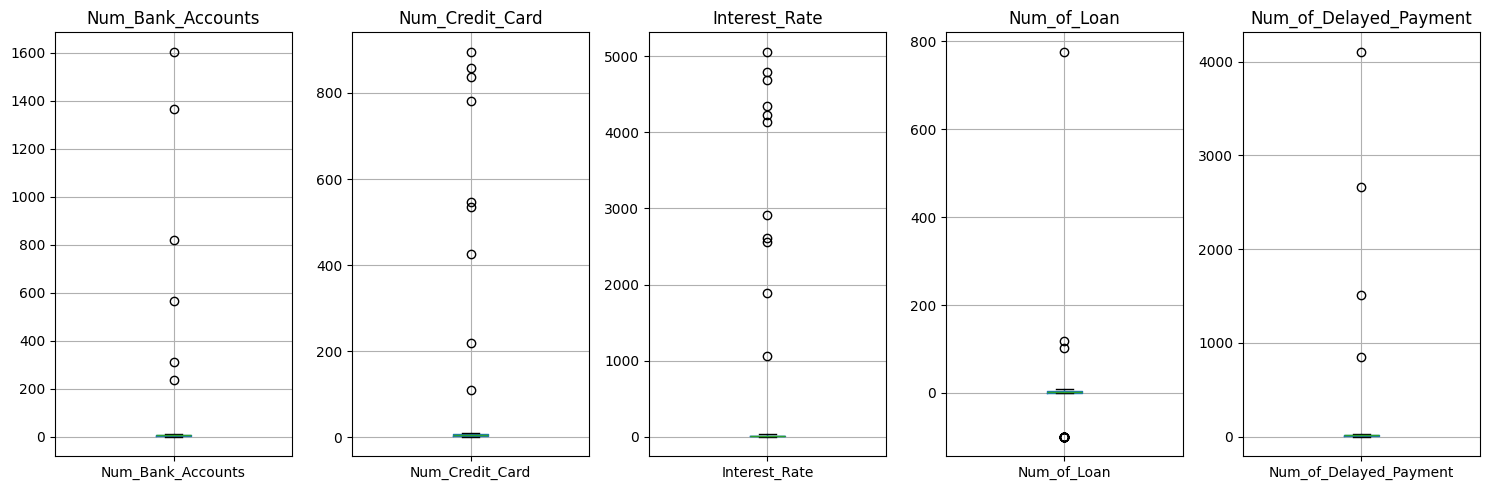

In [193]:
cols =['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Num_of_Delayed_Payment']
fig, axes = plt.subplots(ncols=5, figsize=(15, 5))

for ax, column_name in zip(axes, cols):
    df_financials[[column_name]].boxplot(ax=ax)
    ax.set_title(column_name)
plt.tight_layout()
plt.show()

In [216]:
df_financials.select_dtypes('number').quantile(0.97)

Annual_Income               141085.184000
Monthly_Inhand_Salary        11075.640600
Num_Bank_Accounts               10.000000
Num_Credit_Card                 10.000000
Interest_Rate                   33.000000
Num_of_Loan                      9.000000
Delay_from_due_date             57.000000
Num_of_Delayed_Payment          24.130000
Changed_Credit_Limit            23.830500
Num_Credit_Inquiries            17.000000
Outstanding_Debt              4323.663200
Credit_Utilization_Ratio        40.553561
Total_EMI_per_month           8144.010000
Amount_invested_monthly      10000.000000
Monthly_Balance               1010.679982
Credit_History_Age_Year         32.000000
Credit_History_Age_Month        11.000000
Name: 0.97, dtype: float64

**Categorical attributes**

In [85]:
df_financials['Type_of_Loan'].unique()

array(['Credit-Builder Loan, Auto Loan, Auto Loan, and Mortgage Loan',
       'Personal Loan, Auto Loan, and Not Specified',
       'Student Loan, and Home Equity Loan',
       'Student Loan, Mortgage Loan, and Payday Loan',
       'Payday Loan, Personal Loan, Payday Loan, Personal Loan, Mortgage Loan, Home Equity Loan, Student Loan, Credit-Builder Loan, and Payday Loan',
       'Credit-Builder Loan',
       'Not Specified, Personal Loan, Auto Loan, Not Specified, and Debt Consolidation Loan',
       'Debt Consolidation Loan',
       'Mortgage Loan, Debt Consolidation Loan, and Home Equity Loan',
       nan,
       'Student Loan, Student Loan, Payday Loan, and Credit-Builder Loan',
       'Personal Loan, Debt Consolidation Loan, Personal Loan, Home Equity Loan, Mortgage Loan, Mortgage Loan, and Not Specified',
       'Student Loan, Personal Loan, Auto Loan, and Student Loan',
       'Not Specified, and Mortgage Loan',
       'Payday Loan, Mortgage Loan, and Student Loan',
       'Payda

In [86]:
df_financials['Credit_Mix'].unique()

array(['Good', 'Standard', 'Bad', '_'], dtype=object)

In [87]:
df_financials['Payment_of_Min_Amount'].unique()

array(['No', 'Yes', 'NM'], dtype=object)

In [88]:
df_financials['Payment_Behaviour'].unique()

array(['Low_spent_Small_value_payments',
       'High_spent_Small_value_payments', '!@9#%8',
       'High_spent_Medium_value_payments',
       'High_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Large_value_payments'], dtype=object)

**Observations:**
- Num_of_Loan, Delay_from_due_date, Num_of_Delayed_Payment, and Changed_Credit_Limit contains negative values. For the silver table, we can simply remove that data (any imputation is expected to be done downstream at the gold table level).
- Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, and Num_of_Delayed_Payment have absurdly high values that are most likely errors given the context. Thus, clip the values to the 97th percentile.
- We can split Type_of_Loan into separate columns (e.g. Personal Loan, Student Loan, etc.) that contain the number of loans of each type that they have taken out.
    - Since it might be messy to have all those columns in one table, we can create a separate table to contain them called financials_loan_type.
- We can split Payment_Behaviour into two separate columns Payment_Behaviour_Spent & Payment_Behaviour_Value, with the respective categorical values (Low, High for Spent and Small, Medium, Large for Value. Put NA for !@9#%8)

#### LMS

In [93]:
df_lms.describe()

,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance
count,530.0,530.0,530.0,530.0,530.0,530.0,530.0
mean,10.0,0.0,10000.0,0.0,0.0,0.0,10000.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,10.0,0.0,10000.0,0.0,0.0,0.0,10000.0
25%,10.0,0.0,10000.0,0.0,0.0,0.0,10000.0
50%,10.0,0.0,10000.0,0.0,0.0,0.0,10000.0
75%,10.0,0.0,10000.0,0.0,0.0,0.0,10000.0
max,10.0,0.0,10000.0,0.0,0.0,0.0,10000.0


**Observations:**
- No additional data cleaning necessary
- Would benefit from more descriptive columns ("month on book" to represent installment_num, "days past due" to check how many days the overdue amount has remained)

## Building the silver tables

Now that we know what sort of preprocessing should be done for the silver tables through EDA, we can start building them!

**Create data lake for silver table**

In [5]:
# create silver datalake
silver_directory = "datamart/silver"

if not os.path.exists(silver_directory):
    os.makedirs(silver_directory)

**Functions for processing each table into silver**

In [ ]:
def process_df_attributes(df):
    numeric_regex = r'([-+]?\d*\.?\d+)'
    
    # Extract numeric part from string in 'Age' column
    df = df.withColumn("age", F.regexp_extract(col("age"), numeric_regex, 1))

    # Define column data types
    columns = {
        'customer_id': StringType(),
        'name': StringType(),
        'age': IntegerType(),
        'ssn': StringType(),
        'occupation': StringType(),
        'snapshot_date': DateType()
    }

    # Cast columns to the proper data type
    for column, new_type in columns.items():
        df = df.withColumn(column, col(column).cast(new_type))

    # Enforce valid age constraints
    # The oldest person in the world is a little less than 120 years old, so make everything above that invalid
    # Minimum is 0 because some banks allow opening joint accounts for children
    df = df.withColumn(
        "age",
        F.when((col("age") >= 0) & (col("age") <= 120), col("age"))  # keep valid
        .otherwise(None)  # redact invalid
    ) 

    # Enforce valid SSN
    df = df.withColumn(
        "ssn",
        F.regexp_extract(col("ssn"), r'^(\d{3}-\d{2}-\d{4})$', 1)
    )
    df = df.withColumn(
        "ssn",
        F.when(col("ssn") == "", None).otherwise(col("ssn"))
    )

    # Null empty occupation
    df = df.withColumn(
        "occupation",
        F.when(col("occupation") == "_______", None).otherwise(col("occupation"))
    )
    return df

In [31]:
def process_df_clickstream(df):
    # Define column data types
    columns = {
        **{f'fe_{i}': IntegerType() for i in range(1, 21)},
        'customer_id': StringType(),
        'snapshot_date': DateType()
    }

    # Cast columns to the proper data type
    for column, new_type in columns.items():
        df = df.withColumn(column, col(column).cast(new_type))
    return df

In [32]:
def split_loan_type(loan_type):
    if not isinstance(loan_type, str):
        return {}
    
    loans_list = loan_type.replace(' and ', ',').split(',')

    cleaned = [item.strip().replace(' ', '_').lower() for item in loans_list if item.strip() != '']

    return dict(Counter(cleaned))

def process_df_financials(df, silver_db, snapshot_date_str):
    numeric_regex = r'([-+]?\d*\.?\d+)'
    
    columns = {
        'annual_income': FloatType(),
        'monthly_inhand_salary': FloatType(),
        'num_bank_accounts': IntegerType(),
        'num_credit_card': IntegerType(),
        'interest_rate': IntegerType(),
        'num_of_loan': IntegerType(),
        'delay_from_due_date': IntegerType(),
        'num_of_delayed_payment': IntegerType(),
        'changed_credit_limit': FloatType(),
        'num_credit_inquiries': FloatType(),
        'outstanding_debt': FloatType(),
        'credit_utilization_ratio': FloatType(),
        'total_emi_per_month': FloatType(),
        'amount_invested_monthly': FloatType(),
        'monthly_balance': FloatType()
    }

    # Cast columns to the proper data type
    for col_name, dtype in columns.items():
        df = df.withColumn(col_name, F.regexp_extract(col(col_name), numeric_regex, 1))
        df = df.withColumn(col_name, col(col_name).cast(dtype))

    # Split credit history age
    df = df.withColumn("credit_history_age_year",
                        F.regexp_extract(col('credit_history_age'), r'(\d+)\s+Year', 1))
    df = df.withColumn("credit_history_age_year", col("credit_history_age_year").cast(IntegerType()))
    df = df.withColumn("credit_history_age_month",
                        F.regexp_extract(col('credit_history_age'), r'(\d+)\s+Month', 1))
    df = df.withColumn("credit_history_age_month", col("credit_history_age_month").cast(IntegerType()))

    # Remove negative values from columns that should not have it
    for column_name in ['num_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit']:
        df = df.withColumn(
            column_name,
            F.when(col(column_name) >= 0, col(column_name))  # keep valid
            .otherwise(None)  # redact invalid
        ) 
    
    # Clip outliers to 90th percentile
    for column_name in ['num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'num_of_delayed_payment']:
        percentile_value = df.approxQuantile(column_name, [0.97], 0.01)[0]
        df = df.withColumn(
            column_name,
            F.when(col(column_name) > percentile_value, percentile_value)
            .otherwise(col(column_name))
        )

    # Split payment behaviour
    payment_behaviour_regex = r'(Low|High)_spent_(Small|Medium|Large)_value'
    df = df.withColumn(
        'payment_behaviour_spent',
        F.regexp_extract(col('payment_behaviour'), payment_behaviour_regex, 1)
    )
    df = df.withColumn(
        'payment_behaviour_spent',
        F.when(col('payment_behaviour_spent') != '', col('payment_behaviour_spent'))
        .otherwise(None)
    )
    df = df.withColumn(
        'payment_behaviour_value',
        F.regexp_extract(col('payment_behaviour'), payment_behaviour_regex, 2)
    )
    df = df.withColumn(
        'payment_behaviour_value',
        F.when(col('payment_behaviour_value') != '', col('payment_behaviour_value'))
        .otherwise(None)
    )

    # Null empty credit_mix
    df = df.withColumn(
        "credit_mix",
        F.when(col("credit_mix") == "_", None).otherwise(col("credit_mix"))
    )
    
    ######################################
    # Split loan type into its own table
    ######################################
    df_loan_type = df.select('customer_id', 'snapshot_date', 'type_of_loan')

    # Register helper function as a udf
    split_loan_type_udf = F.udf(split_loan_type, MapType(StringType(), IntegerType()))

    # Apply UDF to column
    df_loan_type = df_loan_type.withColumn("loan_type_counts", split_loan_type_udf(col("Type_of_Loan")))
    all_keys = (
        df_loan_type.select("loan_type_counts")
        .rdd.flatMap(lambda row: row["loan_type_counts"].keys() if row["loan_type_counts"] else [])
        .distinct()
        .collect()
    )

    # Create individual columns for each loan type
    for key in all_keys:
        df_loan_type = df_loan_type.withColumn(
            key,
            F.coalesce(col("loan_type_counts").getItem(key), F.lit(0))
        )

    # Drop intermedate columns
    df_loan_type = df_loan_type.drop("loan_type_counts")
    
    # Save new table
    partition_name = snapshot_date_str.replace('-','_') + '.parquet'
    filepath = os.path.join(silver_db, 'loan_type', partition_name)
    df_loan_type.write.mode("overwrite").parquet(filepath)

    return df.drop('payment_behaviour', 'type_of_loan')

In [33]:
def process_df_lms(df):
    column_type_map = {
        "loan_id": StringType(),
        "customer_id": StringType(),
        "loan_start_date": DateType(),
        "tenure": IntegerType(),
        "installment_num": IntegerType(),
        "loan_amt": FloatType(),
        "due_amt": FloatType(),
        "paid_amt": FloatType(),
        "overdue_amt": FloatType(),
        "balance": FloatType(),
        "snapshot_date": DateType(),
    }

    # Cast columns to proper data type
    for column, new_type in column_type_map.items():
        df = df.withColumn(column, col(column).cast(new_type))

    # Add "month on book" column
    df = df.withColumn("mob", col("installment_num").cast(IntegerType()))

    # Add "days past due" column
    df = df.withColumn("installments_missed", F.ceil(col("overdue_amt") / col("due_amt")).cast(IntegerType())).fillna(0)
    df = df.withColumn("first_missed_date", F.when(col("installments_missed") > 0, F.add_months(col("snapshot_date"), -1 * col("installments_missed"))).cast(DateType()))
    df = df.withColumn("dpd", F.when(col("overdue_amt") > 0.0, F.datediff(col("snapshot_date"), col("first_missed_date"))).otherwise(0).cast(IntegerType()))
    
    return df

In [34]:
def process_silver_table(table_name, bronze_db, silver_db, snapshot_date_str, spark):
    # connect to bronze table
    partition_name = snapshot_date_str.replace('-','_') + '.csv'
    filepath = os.path.join(bronze_db, table_name, partition_name)
    df = spark.read.csv(filepath, header=True, inferSchema=True)

    # Change all column names to be lowercase
    df = df.toDF(*[col_name.lower() for col_name in df.columns])

    if table_name == "attributes":
        df = process_df_attributes(df)
    elif table_name == 'clickstream':
        df = process_df_clickstream(df)
    elif table_name == "financials":
        df = process_df_financials(df, silver_db, snapshot_date_str)   
    elif table_name == "lms":
        df = process_df_lms(df)
    else:
        raise ValueError("Table does not exist!")

    # Save silver table
    partition_name = snapshot_date_str.replace('-','_') + '.parquet'
    filepath = os.path.join(silver_db, table_name, partition_name)
    df.write.mode("overwrite").parquet(filepath)
    return df

**Create silver tables**

In [40]:
for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing clickstream"):
    process_silver_table('clickstream', bronze_directory, silver_directory, date_str, spark)

for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing attributes"):
    process_silver_table('attributes', bronze_directory, silver_directory, date_str, spark)

for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing financials"):
    process_silver_table('financials', bronze_directory, silver_directory, date_str, spark)

for date_str in tqdm(dates_str_lst, total=len(dates_str_lst), desc="Processing lms"):
    process_silver_table('lms', bronze_directory, silver_directory, date_str, spark)

Processing lms: 100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


# Build Gold Tables

The goal of the gold table is to have a **feature store** and **label store** for training the CreditKarma Scorer model.

CreditKarma Scorer takes in a customer ID and aggregates relevant attributes tied to the user, then outputs a score from 0-1 based on those attributes that denotes the probability of **the customer defaulting a loan**. CreditKarma Scorer uses a **logistic regression** under the hood, as we must be able to explain how loan decisions are made.

## EDA

**Read silver tables**

In [16]:
def read_silver_table(table, silver_db, spark):
    folder_path = os.path.join(silver_db, table)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df

In [69]:
# Feature store silver tables
df_attributes = read_silver_table('attributes', silver_directory, spark)
df_clickstream = read_silver_table('clickstream', silver_directory, spark)
df_financials = read_silver_table('financials', silver_directory, spark)
df_loan_type = read_silver_table('loan_type', silver_directory, spark)

# Label store silver tables
df_lms = read_silver_table('lms', silver_directory, spark)

### Label Store

Inspect distribution of target variable to engineer stable labels. Our goal is to decide the probability of a customer defaulting a loan should the loan be granted to them. As such, we must derive a definition of what "default" means based on the historical loan repayment data.

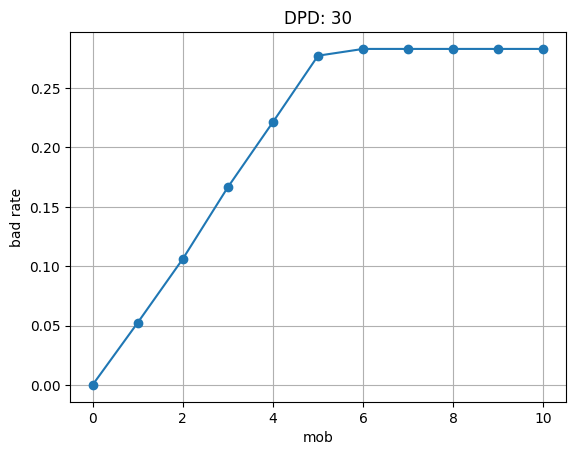

In [8]:
dpd = 30

# filter only completed loans
df_label = df_lms.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df_label = df_label.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df_label.filter(col("installment_num") == 10)

# visualise bad rate
pdf = df_label.toPandas()

# Group by mob and count occurrences in dpd_flag
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


**Observations**
- If a customer is on their 6th month on book and still has payments that are 30 days past due, it is unlikely they will pay them off before the tenure. Hence, these customers are marked as "bad customers".

In [9]:
df_label = df_lms.filter(col("mob")==6)
df_label.select('customer_id').distinct().count()

8974

- There are only 8974 customers with 6 months of data, as opposed to the whole dataset of 11974 users. This is because some users might take out a loan later. We would usually call these users to be **right-censored data**. However, since we are doing **binary classification** instead of [survival analysis](https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html), we can drop these users.

### Feature Store

Inspect features to know which ones to include in the model.

**Join financials, attributes, and loan_type tables for easier analysis**

In [10]:
df_joined = df_attributes.join(df_financials, on=["customer_id", "snapshot_date"], how="inner")
df_joined = df_joined.join(df_loan_type, on=["customer_id", "snapshot_date"], how="inner")
df_joined = df_joined.drop("name", "ssn", "type_of_loan", "credit_history_age", "type_of_loan") # drop identifiers and duplicated columns
df_joined = df_joined.join(df_label.select("customer_id"), on="customer_id", how="left_semi")# filter by user IDs that have labels

In [11]:
df_joined.show(5)

+-----------+-------------+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+---------------+-----------------------+------------------------+-----------------------+-----------------------+-------------+---------+-------------------+-------------+-------------+------------+----------------+-----------+-----------------------+
|customer_id|snapshot_date|age|occupation|annual_income|monthly_inhand_salary|num_bank_accounts|num_credit_card|interest_rate|num_of_loan|delay_from_due_date|num_of_delayed_payment|changed_credit_limit|num_credit_inquiries|credit_mix|outstanding_debt|credit_utilization_ratio|payment_of_min_amount|total_emi_per_month|amount_invested_monthly|monthly_balance|credit_history_age_year|credit_history_age_month

**Correlation analysis of numeric variables**

In [12]:
def show_correlation_map(corr_df, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(corr_df, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    # Add labels
    for i in range(len(corr_df.columns)):
        for j in range(len(corr_df.index)):
            plt.text(i, j, f'{corr_df.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=5)
    plt.xticks(np.arange(len(corr_df.columns)), corr_df.columns, rotation=90)
    plt.yticks(np.arange(len(corr_df.index)), corr_df.index)

    plt.show()

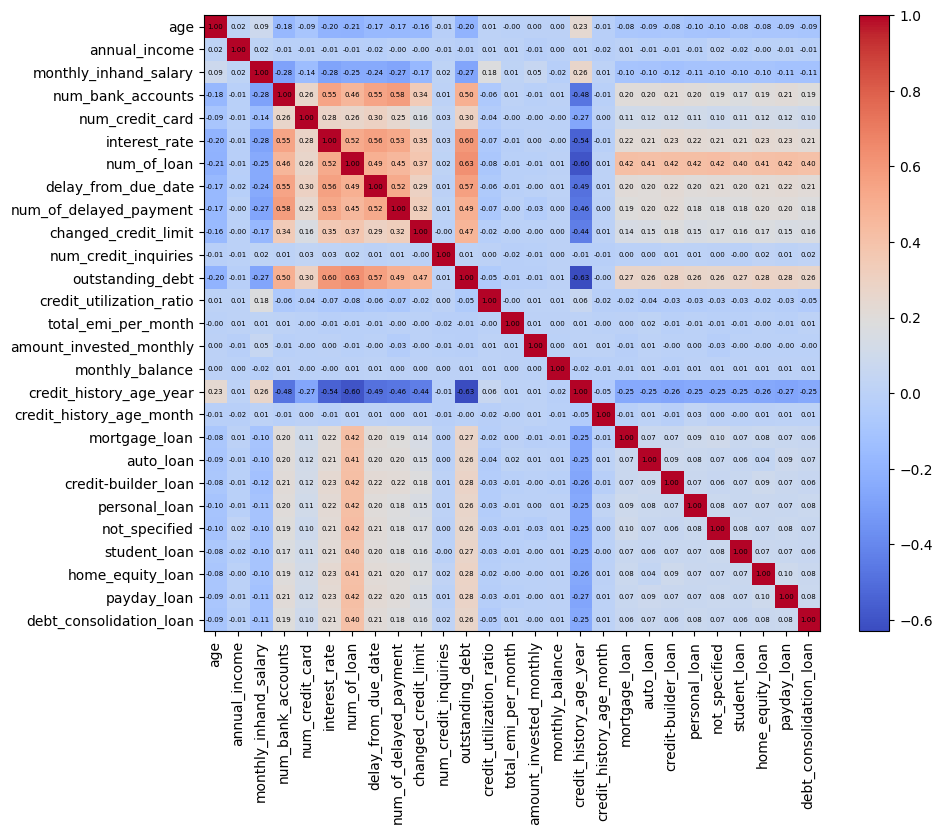

In [13]:
# Extract numeric columns for computing correlation
numeric_columns = [column for column in df_joined.columns if isinstance(df_joined.schema[column].dataType, NumericType)]
df_corr = df_joined.select(*numeric_columns).toPandas().corr()

# Show heatmap
show_correlation_map(df_corr)

It seems that there are no very strong correlation between any of the numeric variables, with the strongest being a relationship between credit_history_age_year and outstanding_debt (0.63). We can keep all the features.

**PCA (clickstream)**

As clickstream has a large number of features, we can try to compress them into fewer features through dimensionality reduction (PCA).

In [53]:
df_label_renamed = df_label.withColumnRenamed("snapshot_date", "mob_date")
df_label_renamed = df_label_renamed.select("customer_id", "mob_date")

In [54]:
df_clickstream_filtered = df_clickstream.join(df_label_renamed, on="customer_id", how="inner") # filter by user IDs that have labels
df_clickstream_filtered = df_clickstream_filtered.filter(col("snapshot_date") < col("mob_date")) # get clickstream data before the label date

In [ ]:
# Aggregate for each user
agg_exprs = [F.avg(f'fe_{i}').alias(f"avg_fe_{i}") for i in range(1, 21)]
df_clickstream_filtered = df_clickstream_filtered.groupBy("customer_id").agg(*agg_exprs)

Perform PCA

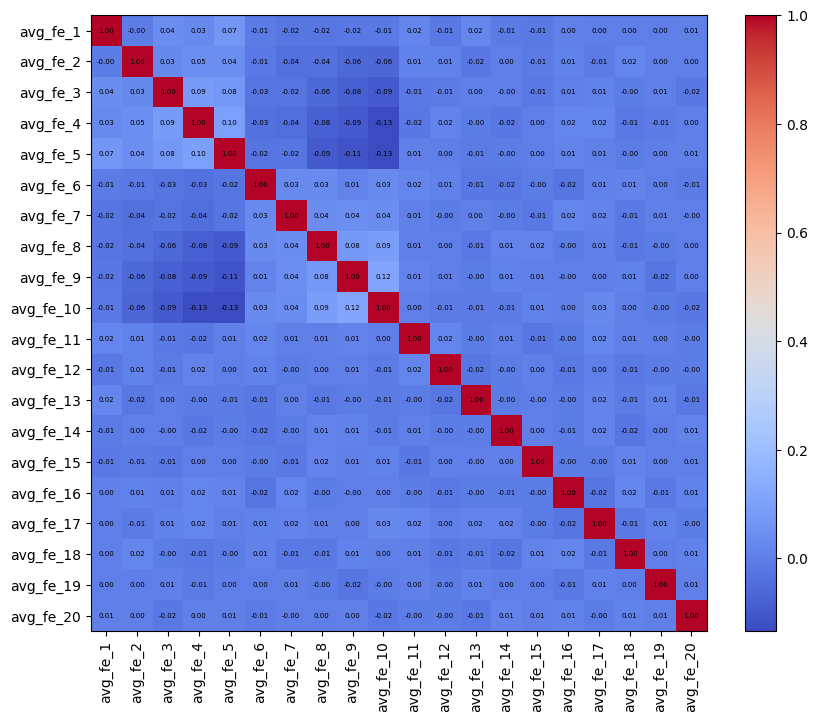

In [63]:
df_clickstream_filtered = df_clickstream_filtered.toPandas().drop(columns=['customer_id'])
df_clickstream_corr = df_clickstream_filtered.corr()
show_correlation_map(df_clickstream_corr)

In [ ]:
# Normalize data first because PCA is sensitive to scale
df_clickstream_filtered = sklearn.preprocessing.StandardScaler().fit_transform(df_clickstream_filtered)

# Perform PCA
for i in range(1, 10):
    pca = PCA(n_components=i)
    pca_features = pca.fit_transform(df_clickstream_filtered)
    df_pca = pd.DataFrame(pca_features)

    print("n_components: ", i)
    print("Explained variance by each component:", pca.explained_variance_ratio_)

n_components:  1
Explained variance by each component: [0.07721939]
n_components:  2
Explained variance by each component: [0.07721939 0.05372818]
n_components:  3
Explained variance by each component: [0.07721939 0.05372818 0.0528927 ]
n_components:  4
Explained variance by each component: [0.07721939 0.05372818 0.0528927  0.05227325]
n_components:  5
Explained variance by each component: [0.07721939 0.05372818 0.0528927  0.05227325 0.05159836]
n_components:  6
Explained variance by each component: [0.07721939 0.05372818 0.0528927  0.05227325 0.05159836 0.05121591]
n_components:  7
Explained variance by each component: [0.07721939 0.05372818 0.0528927  0.05227325 0.05159836 0.05121591
 0.05062152]
n_components:  8
Explained variance by each component: [0.07721939 0.05372818 0.0528927  0.05227325 0.05159836 0.05121591
 0.05062152 0.05018828]
n_components:  9
Explained variance by each component: [0.07721939 0.05372818 0.0528927  0.05227325 0.05159836 0.05121591
 0.05062152 0.05018828 0

- Seems like PCA is not useful for compressing the data because the features do not have strong linear correlations.

## Building the Gold Tables

**What sort of preprocessing do we need to do to build gold tables?**

Label store:
- Label customers according to the definition of default (6 months on book with more than 30 days past due)
- Do a stratified train test split

Feature store:
- Impute NULL variables for numeric data
- Turn categorical columns into one hot encoding
- Filter clickstream data to only data before the date labels are decided for the corresponding customer
- Join attributes, financials, and clickstream data together into a single matrix
- Normalize data because logistic regression is sensitive to scale

**Create data lake for gold tables**

In [20]:
# create gold datalake
gold_directory = "datamart/gold"

if not os.path.exists(gold_directory):
    os.makedirs(gold_directory)

## Label Store Functions

In [38]:
def build_label_store(mob, dpd, silver_db, gold_db, partitions_list, spark, train_ratio=0.8, seed=42):
    label_table = 'lms' # hard coded

    # Connect to silver table, read all partitions
    df = read_silver_table(label_table, silver_db, spark)

    ####################
    # Create labels
    ####################

    # get customer at mob
    df = df.filter(col("mob") == mob)

    # get label
    df = df.withColumn("label", F.when(col("dpd") >= dpd, 1).otherwise(0).cast(IntegerType()))
    df = df.withColumn("label_def", F.lit(str(dpd)+'dpd_'+str(mob)+'mob').cast(StringType()))

    # select columns to save
    df = df.select("loan_id", "customer_id", "label", "label_def", "snapshot_date")

    #####################
    # Do train test split
    #####################
    label_counts = df.groupBy("label").count().collect()
    fractions = {row["label"]: train_ratio for row in label_counts}

    df_train = df.stat.sampleBy("label", fractions=fractions, seed=42)
    df_test = df.join(df_train, on=df.columns, how="left_anti")


    ######################
    # save gold table - IRL connect to database to write
    ###################### 

    # Partition and save train data
    for date_str in tqdm(partitions_list, total=len(partitions_list), desc="Saving train labels"):
        partition_name = date_str.replace('-','_') + '.parquet'
        train_filepath = os.path.join(gold_db, 'label_store', 'train', partition_name)
        df_train.filter(col('snapshot_date')==date_str).write.mode('overwrite').parquet(train_filepath)

    
    # Partition and save test data
    for date_str in tqdm(partitions_list, total=len(partitions_list), desc="Saving test labels"):
        partition_name = date_str.replace('-','_') + '.parquet'
        test_filepath = os.path.join(gold_db, 'label_store', 'test', partition_name)
        df_test.filter(col('snapshot_date')==date_str).write.mode('overwrite').parquet(test_filepath)
    
    return df_train, df_test

## Feature Store Functions

In [76]:
def one_hot_encoder(df, category_col):
    # Get label encoding
    indexer = StringIndexer(inputCol=category_col, outputCol=f"{category_col}_index", handleInvalid="keep")
    indexer_model = indexer.fit(df)
    df = indexer_model.transform(df)

    # Transform into one hot encoding
    encoder = OneHotEncoder(inputCol=f"{category_col}_index", outputCol=f"{category_col}_ohe", dropLast=False)
    df = encoder.fit(df).transform(df)
    vector_to_array_udf = F.udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
    df = df.withColumn(f"{category_col}_array", vector_to_array_udf(f"{category_col}_ohe"))

    # Split into columns
    categories = [cat.lower() for cat in indexer_model.labels]

    for i, cat in enumerate(categories):
        df = df.withColumn(f"{category_col}_{cat}", df[f"{category_col}_array"][i])
        df = df.withColumn(f"{category_col}_{cat}", col(f"{category_col}_{cat}").cast(IntegerType()))

    # Optional: drop intermediate columns
    df = df.drop(category_col, f"{category_col}_index", f"{category_col}_ohe", f"{category_col}_array")
    return df

In [ ]:
def build_feature_store(df_attributes, df_financials, df_loan_type, df_clickstream, df_label):
    #############
    # Join attributes and financials into a single matrix
    #############
    df_joined = df_attributes.join(df_financials, on=["customer_id", "snapshot_date"], how="inner")
    df_joined = df_joined.join(df_loan_type, on=["customer_id", "snapshot_date"], how="inner")
    df_joined = df_joined.drop("name", "ssn", "type_of_loan", "credit_history_age", "type_of_loan") # drop identifiers and duplicated columns
    df_joined = df_joined.join(df_label.select("customer_id"), on="customer_id", how="left_semi") # filter by user IDs that have labels

    print("1. Joined dataframes")

    #############
    # Impute mean into null numeric variables
    #############
    numeric_columns = [column for column in df_joined.columns if isinstance(df_joined.schema[column].dataType, NumericType)]
    imputer = Imputer(inputCols=numeric_columns, outputCols=numeric_columns)
    df_joined = imputer.fit(df_joined).transform(df_joined)

    print("2. Imputed mean into numeric variables")

    #############
    # Turn categorical variables into one hot encoded columns
    #############
    df_joined = one_hot_encoder(df_joined, "occupation")
    df_joined = one_hot_encoder(df_joined, "payment_of_min_amount")
    df_joined = one_hot_encoder(df_joined, "credit_mix")
    df_joined = one_hot_encoder(df_joined, "payment_behaviour_spent")
    df_joined = one_hot_encoder(df_joined, "payment_behaviour_value")

    print("3. Performed one-hot encoding")

    #############
    # Aggregate mean clickstream data for each user
    #############

    # Filter clickstream data
    df_label_renamed = df_label.withColumnRenamed("snapshot_date", "mob_date")
    df_label_renamed = df_label_renamed.select("customer_id", "mob_date")  
    df_clickstream_filtered = df_clickstream.join(df_label_renamed, on="customer_id", how="inner") # filter by user IDs that have labels
    df_clickstream_filtered = df_clickstream_filtered.filter(col("snapshot_date") < col("mob_date")) # get clickstream data before the label date

    # Do mean aggregation
    agg_exprs = [F.avg(f'fe_{i}').alias(f"avg_fe_{i}") for i in range(1, 21)]
    df_clickstream_filtered = df_clickstream_filtered.groupBy("customer_id").agg(*agg_exprs)

    print("4. Processed clickstream data")

    #############
    # Join clickstream data with attributes and financials
    #############
    df_joined = df_joined.join(df_clickstream_filtered, on=["customer_id"], how="left")

    print("5. Joined clickstream data with the rest of the features")

    #############
    # Normalize data
    #############
    numeric_columns = numeric_columns + [f"avg_fe_{i}" for i in range(1, 21)]

    # Create vector column
    assembler = VectorAssembler(
        inputCols=numeric_columns,
        outputCol="features"
    )
    df_vector = assembler.transform(df_joined)

    # Scale the vector
    scaler = StandardScaler(
        inputCol="features",
        outputCol="scaled_features",
        withMean=True,
        withStd=True
    )
    scaler_model = scaler.fit(df_vector)
    df_joined = scaler_model.transform(df_vector)

    # Convert vector column to array
    vector_to_array_udf = F.udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
    df_joined = df_joined.withColumn("scaled_features_array", vector_to_array_udf("scaled_features"))

    # Override the columns
    for i, col_name in enumerate(numeric_columns):
        df_joined = df_joined.withColumn(col_name, col("scaled_features_array")[i])

    df_joined = df_joined.drop("features", "scaled_features", "scaled_features_array")

    print("6. Normalized data")

    return df_joined

## Build Feature and Label Store

In [ ]:
def process_gold_table(silver_db, gold_db, partitions_list, spark):
    # Build label store
    print("Build label store:")
    df_train_label, df_test_label = build_label_store(6, 30, silver_db, gold_db, partitions_list, spark)
 
    # Read silver tables
    df_attributes = read_silver_table('attributes', silver_db, spark)
    df_clickstream = read_silver_table('clickstream', silver_db, spark)
    df_financials = read_silver_table('financials', silver_db, spark)
    df_loan_type = read_silver_table('loan_type', silver_db, spark)

    # Build train features
    print("Build train features:")
    df_train_features = build_feature_store(df_attributes, df_financials, df_loan_type, df_clickstream, df_train_label)

    # Build test features
    print("Build test features:")
    df_test_features = build_feature_store(df_attributes, df_financials, df_loan_type, df_clickstream, df_test_label)

    # Partition and save train features
    for date_str in tqdm(partitions_list, total=len(partitions_list), desc="Saving train features"):
        partition_name = date_str.replace('-','_') + '.parquet'
        train_filepath = os.path.join(gold_db, 'feature_store', 'train', partition_name)
        df_train_features.filter(col('snapshot_date')==date_str).write.mode('overwrite').parquet(train_filepath)

    # Partition and save test data
    for date_str in tqdm(partitions_list, total=len(partitions_list), desc="Saving test features"):
        partition_name = date_str.replace('-','_') + '.parquet'
        test_filepath = os.path.join(gold_db, 'feature_store', 'test', partition_name)
        df_test_features.filter(col('snapshot_date')==date_str).write.mode('overwrite').parquet(test_filepath)

    return df_train_features, df_train_label, df_test_features, df_test_label

In [ ]:
X_train, y_train, X_test, y_test = process_gold_table(silver_directory, gold_directory, dates_str_lst, spark)

Build label store:


Saving train labels:  33%|███▎      | 8/24 [00:09<00:18,  1.14s/it]             Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
Saving test labels: 100%|██████████| 24/24 [00:40<00:00,  1.68s/it]             


Build train features:
1. Joined dataframes
2. Imputed mean into numeric variables
3. Performed one-hot encoding
4. Processed clickstream data
5. Joined clickstream data with the rest of the features


6. Normalized data
Build test features:
1. Joined dataframes
2. Imputed mean into numeric variables
3. Performed one-hot encoding
4. Processed clickstream data
5. Joined clickstream data with the rest of the features


6. Normalized data


Saving test features: 100%|██████████| 24/24 [02:01<00:00,  5.04s/it]           


In [100]:
X_train.show(5)

+-----------+-------------+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+-----------------------+------------------------+-------------+----------+-------------------+-------------+-------------+------------+----------------+-----------+-----------------------+-----------------+------------------+-----------------+-------------------+--------------------+--------------------+-------------------+--------------------+------------------------+---------------------+-----------------------+---------------------+-------------------+-----------------+------------------+-------------------------+------------------------+------------------------+-------------------+---------------+--------------+---------------------------+---------------------------

In [101]:
X_test.show(5)

+-----------+-------------+-----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+-------------------+-----------------------+---------------+-----------------------+------------------------+-------------+----------+-------------------+-------------+-------------+------------+----------------+-----------+-----------------------+---------------------+------------------------+--------------------+-------------------+-----------------------+---------------------+--------------------+-----------------+--------------------+-----------------+-------------------+-------------------+-----------------+------------------+------------------+-------------------------+------------------------+------------------------+-------------------+---------------+--------------+---------------------------+---------------------------

In [102]:
y_train.show(5)

+--------------------+-----------+-----+----------+-------------+
|             loan_id|customer_id|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x100b_2024_0...| CUS_0x100b|    0|30dpd_6mob|   2024-09-01|
|CUS_0x1096_2024_0...| CUS_0x1096|    1|30dpd_6mob|   2024-09-01|
|CUS_0x112d_2024_0...| CUS_0x112d|    1|30dpd_6mob|   2024-09-01|
|CUS_0x1204_2024_0...| CUS_0x1204|    1|30dpd_6mob|   2024-09-01|
|CUS_0x12af_2024_0...| CUS_0x12af|    0|30dpd_6mob|   2024-09-01|
+--------------------+-----------+-----+----------+-------------+
only showing top 5 rows



In [103]:
y_test.show(5)

+--------------------+-----------+-----+----------+-------------+
|             loan_id|customer_id|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x111c_2024_0...| CUS_0x111c|    1|30dpd_6mob|   2024-09-01|
|CUS_0x12cb_2024_0...| CUS_0x12cb|    1|30dpd_6mob|   2024-09-01|
|CUS_0x144c_2024_0...| CUS_0x144c|    0|30dpd_6mob|   2024-09-01|
|CUS_0x1695_2024_0...| CUS_0x1695|    0|30dpd_6mob|   2024-09-01|
|CUS_0x1931_2024_0...| CUS_0x1931|    1|30dpd_6mob|   2024-09-01|
+--------------------+-----------+-----+----------+-------------+
only showing top 5 rows

